# Hotspot definition and control construction

In [70]:
# --- CONFIG ---------------------------------------------------------------
HOT_FLAG_COL   = "is_hot"          # boolean: True for hotspot lixels
DENSITY_COL    = "density_bw200"   # numeric density column (e.g., NKDE value)
ROADCLASS_COL  = "fclass"          # road class column
PROV_NAME_COL  = "ADM1_TH"         # province name (will be attached later)
BUFFER_METERS  = 75                # strict-nonhot buffer distance
RANDOM_SEED    = 42                # sampling seed
# -------------------------------------------------------------------------

import numpy as np
import pandas as pd
import geopandas as gpd

# ---- Load your data ------------------------------------------------------
lixels_100 = gpd.read_file("roadnetwork/hotspot_top1.gpkg", layer="lixels100_bw200")
L = lixels_100.to_crs(epsg=3857).copy()

prov = gpd.read_file(
    "/Users/stupong/Desktop/ThaiRAP/osm/tha_adm_rtsd_itos_20210121_shp/tha_admbnda_adm1_rtsd_20220121.shp"
).to_crs(L.crs).explode(index_parts=False).reset_index(drop=True)

# ---- Keep only needed columns early (reduces join cost) -----------------
need_cols = [HOT_FLAG_COL, DENSITY_COL, ROADCLASS_COL, "geometry","ref"]
L = L[need_cols].copy().reset_index(drop=True)
L[ROADCLASS_COL] = L[ROADCLASS_COL].fillna("UNK_CLASS")
L["length_m"] = L.geometry.length.astype(float)

# ---- Hotspots & Non-hot --------------------------------------------------
H = L[L[HOT_FLAG_COL]].copy()
nonhot = L[~L[HOT_FLAG_COL]].copy()

total_hotspot_length_m = float(H["length_m"].sum())
print(f"Total hotspot length: {total_hotspot_length_m/1000:.2f} km")

# ---- Strict non-hot via fast nearest-with-cap (NO buffering/union) ------
# Mark non-hot lixels that are within 75 m of ANY hotspot, then drop them.
# Requires GeoPandas >= 0.12 / Shapely >= 2.0 for best performance.
near = gpd.sjoin_nearest(
    nonhot[["geometry"]],      # only geometry for speed
    H[["geometry"]],
    how="inner",
    max_distance=BUFFER_METERS,
    distance_col="dist_m"
)
N = nonhot.drop(index=near.index.unique()).copy()
print(f"Strict non-hot lixels: {len(N):,}")

# ---- Attach province ONLY to H and N (after size reduction) --------------
def attach_province(gdf):
    out = gpd.sjoin(
        gdf, prov[[PROV_NAME_COL, "geometry"]],
        how="left", predicate="intersects"
    ).drop(columns=["index_right"])
    out[PROV_NAME_COL] = out[PROV_NAME_COL].fillna("UNK_PROV")
    return out

H = attach_province(H)
N = attach_province(N)

# ---- Row-matched, stratified controls (province × road class) -----------
def stratified_match_with_reallocation(pool_df, target_counts, group_cols, n_total, random_state=RANDOM_SEED):
    rng = np.random.default_rng(random_state)
    pool_df = pool_df.copy()

    avail = pool_df.groupby(group_cols, dropna=False).size().rename("avail")
    target = target_counts.rename("target").to_frame()

    mix = target.join(avail, how="left").fillna({"avail": 0})
    mix["take"] = mix[["target", "avail"]].min(axis=1).astype(int)

    deficit = int(n_total - mix["take"].sum())
    if deficit > 0 and (mix["avail"] > mix["take"]).any():
        mix["surplus"] = (mix["avail"] - mix["take"]).clip(lower=0).astype(int)
        total_surplus = int(mix["surplus"].sum())
        if total_surplus > 0:
            prop = (mix["surplus"] / total_surplus) * deficit
            floor_alloc = np.floor(prop).astype(int)
            remainder = deficit - int(floor_alloc.sum())
            mix["take"] += floor_alloc
            if remainder > 0:
                frac = prop - floor_alloc
                extra_idx = frac.sort_values(ascending=False).head(remainder).index
                mix.loc[extra_idx, "take"] += 1
            mix["take"] = mix[["take", "avail"]].min(axis=1).astype(int)

    pool_df = pool_df.sample(frac=1.0, random_state=random_state)
    sampled = []
    for g, take in mix["take"].items():
        if take <= 0:
            continue
        sel = (pool_df[group_cols] == pd.Series(g, index=group_cols)).all(axis=1)
        grp_df = pool_df.loc[sel]
        sampled.append(grp_df if len(grp_df) <= take else grp_df.sample(n=take, random_state=random_state))
    out = pd.concat(sampled, axis=0) if sampled else pool_df.iloc[0:0]

    if len(out) < n_total:
        remaining = pool_df.loc[~pool_df.index.isin(out.index)]
        need = n_total - len(out)
        if need > 0 and len(remaining) > 0:
            out = pd.concat([out, remaining.sample(n=min(need, len(remaining)), random_state=random_state)], axis=0)
    return out

group_cols = [PROV_NAME_COL, ROADCLASS_COL]
hot_counts = H.groupby(group_cols, dropna=False).size()
n_hot = int(len(H))

C = stratified_match_with_reallocation(
    pool_df=N,
    target_counts=hot_counts,
    group_cols=group_cols,
    n_total=n_hot,
    random_state=RANDOM_SEED
).copy()
C["control_type"] = "row_matched_strict_nonhot"
print(f"Row-matched controls: {len(C):,}")

# ---- Sensitivity (i): Hard negatives = next 1% by total length ----------
nonhot_sorted = (
    L.loc[~L[HOT_FLAG_COL], [DENSITY_COL, "length_m"]]
      .sort_values(DENSITY_COL, ascending=False)
      .reset_index()               # original idx -> "index"
      .rename(columns={"index": "orig_idx"})
)
nonhot_sorted["cum_len_m"] = nonhot_sorted["length_m"].astype(float).cumsum()
mask = nonhot_sorted["cum_len_m"] <= total_hotspot_length_m
if mask.any():
    k = int(mask.sum())
    take_rows = nonhot_sorted.iloc[:min(k+1, len(nonhot_sorted))] \
        if (k < len(nonhot_sorted)) and (nonhot_sorted.loc[k-1, "cum_len_m"] < total_hotspot_length_m) \
        else nonhot_sorted.iloc[:k]
else:
    take_rows = nonhot_sorted.iloc[:1]

hard_neg = L.loc[take_rows["orig_idx"].values].copy()
hard_neg["control_type"] = "hard_negatives_next1pct_len"
print(f"Hard negatives: {len(hard_neg):,} "
      f"(cum_len={take_rows['length_m'].sum()/1000:.2f} km; "
      f"target={total_hotspot_length_m/1000:.2f} km)")

# ---- Sensitivity (ii): Low-but-nonzero (lowest decile) -------------------
nonhot_pos = L.loc[~L[HOT_FLAG_COL] & (L[DENSITY_COL] > 0),
                   [DENSITY_COL, "length_m", ROADCLASS_COL, "geometry"]]
if len(nonhot_pos) > 0:
    p10 = np.percentile(nonhot_pos[DENSITY_COL].values, 10)
    low_decile = nonhot_pos[nonhot_pos[DENSITY_COL] <= p10]
    if len(low_decile) >= n_hot:
        low_nonzero = low_decile.sample(n=n_hot, random_state=RANDOM_SEED).copy()
    else:
        need = n_hot - len(low_decile)
        p20 = np.percentile(nonhot_pos[DENSITY_COL].values, 20)
        band = nonhot_pos[(nonhot_pos[DENSITY_COL] > p10) & (nonhot_pos[DENSITY_COL] <= p20)]
        topup = band.sample(n=min(need, len(band)), random_state=RANDOM_SEED) if len(band) else band.iloc[0:0]
        low_nonzero = pd.concat([low_decile, topup], axis=0).copy()
else:
    low_nonzero = L.iloc[0:0].copy()
low_nonzero["control_type"] = "low_nonzero_lowest_decile"
print(f"Low-but-nonzero controls: {len(low_nonzero):,}")

# ---- Sensitivity (iii): Zero-density ------------------------------------
zero_pool = L.loc[(~L[HOT_FLAG_COL]) & (L[DENSITY_COL] == 0)]
zero_controls = (zero_pool.sample(n=n_hot, random_state=RANDOM_SEED).copy()
                 if len(zero_pool) >= n_hot else zero_pool.copy())
zero_controls["control_type"] = "zero_density"
print(f"Zero-density controls: {len(zero_controls):,}")

# ---- Summary table -------------------------------------------------------
def tab(df, name):
    if len(df) == 0:
        return pd.Series(dtype=int, name=name)
    # province was only attached to H and N; attach to others on demand for the table
    if PROV_NAME_COL not in df.columns:
        df = gpd.sjoin(df, prov[[PROV_NAME_COL, "geometry"]], how="left", predicate="intersects") \
               .drop(columns=["index_right"])
        df[PROV_NAME_COL] = df[PROV_NAME_COL].fillna("UNK_PROV")
    return df.groupby([PROV_NAME_COL, ROADCLASS_COL]).size().rename(name)

summary = pd.concat(
    [
        tab(H, "hotspots"),
        tab(C, "row_matched"),
        tab(hard_neg, "hard_neg"),
        tab(low_nonzero, "low_nonzero"),
        tab(zero_controls, "zero_density"),
    ],
    axis=1
).fillna(0).astype(int).sort_index()

print("\nStratification summary (province × road class):")
print(summary.head(20))
print(f"\nSizes — H: {len(H):,}, C: {len(C):,}, "
      f"hard: {len(hard_neg):,}, low-nonzero: {len(low_nonzero):,}, zero: {len(zero_controls):,}")


Total hotspot length: 1395.53 km
Strict non-hot lixels: 1,297,307
Row-matched controls: 14,387
Hard negatives: 13,930 (cum_len=1395.62 km; target=1395.53 km)
Low-but-nonzero controls: 14,387
Zero-density controls: 14,387

Stratification summary (province × road class):
                              hotspots  row_matched  hard_neg  low_nonzero  \
ADM1_TH       fclass                                                         
UNK_PROV      primary                0            0         0            0   
              secondary              0            0         0            0   
              tertiary               0            0         0            0   
              trunk                  0            0         0            0   
กระบี่        primary                0            0         0            0   
              secondary             56           56        45           45   
              secondary_link         3            3         0            0   
              tertiary      

In [88]:
L

,is_hot,density_bw200,fclass,geometry,ref,length_m
0,False,0.000000,primary_link,"LINESTRING (11192236.42 1557769.067, 11192215....",302,61.934128
1,False,0.000000,trunk,"LINESTRING (11170509.06 1902991.283, 11170608....",126,104.948621
2,False,0.000000,trunk,"LINESTRING (11170608.138 1902956.675, 11170672...",126,104.955877
3,False,0.000000,trunk,"LINESTRING (11170706.573 1902920.34, 11170730....",126,104.985776
4,False,0.000000,trunk,"LINESTRING (11170802.355 1902877.662, 11170892...",126,105.044875
...,...,...,...,...,...,...
1340308,True,0.000315,secondary_link,"LINESTRING (11259808.921 1457885.804, 11259812...",None,7.883175
1340309,False,0.000000,tertiary,"LINESTRING (11177626.806 1546016.517, 11177615...",None,44.031954
1340310,True,0.000230,primary,"LINESTRING (11422953.501 1815331.71, 11422956....",None,16.034688
1340311,False,0.000000,secondary,"LINESTRING (10943508.514 904836.872, 10943521....",None,13.626869


In [89]:
C['ref'].nunique()

2346

<Axes: >

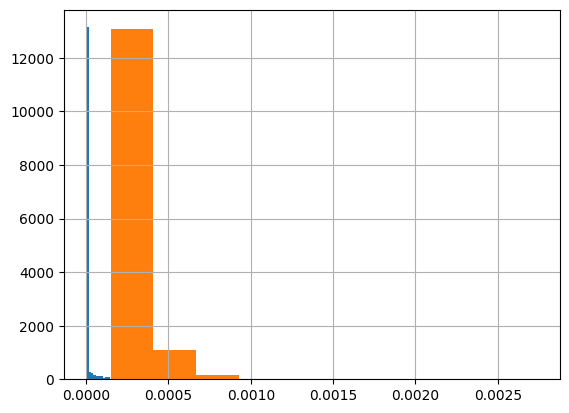

In [90]:
C['density_bw200'].hist()
L[L['is_hot'] == True]['density_bw200'].hist()

In [126]:
# save
# === ONE-LAYER WITH *ALL* LIXELS, DENSITY + LABELS =======================
import os

out_dir = "roadnetwork/outputs_bw200"
os.makedirs(out_dir, exist_ok=True)

# Build flags on the full L
L_all = L.copy()
L_all["is_hot"] = L_all[HOT_FLAG_COL].astype(bool)
L_all["is_control"] = L_all.index.isin(C.index)

# 'near' was created by sjoin_nearest(nonhot, H, max_distance=BUFFER_METERS)
near_idx = near.index.unique() if "near" in locals() else pd.Index([])
L_all["near_hot_75m"] = L_all.index.isin(near_idx)

# strict pool membership (outside the 75 m buffer, non-hot)
L_all["in_strict_pool"] = (~L_all["is_hot"]) & (~L_all["near_hot_75m"])

# Human-readable label for every lixel
L_all["label"] = np.where(
    L_all["is_hot"], "hotspot",
    np.where(
        L_all["is_control"], "control",
        np.where(L_all["in_strict_pool"], "nonhot_strict", "nonhot_near_hot")
    )
)
L_all["label"] = pd.Categorical(
    L_all["label"],
    categories=["hotspot", "control", "nonhot_strict", "nonhot_near_hot"]
)

# Keep just what you said you need: geometry + density + label (add more if useful)
keep_cols = ["label", DENSITY_COL, "geometry", "fclass","ref","length_m"]  # you can also add ROADCLASS_COL if you want
G_all = L_all[keep_cols].copy()

# Save a single GeoPackage layer (good for QGIS) and a GeoParquet (fast reload)
gpkg_path    = os.path.join(out_dir, "lixels_all_bw200.gpkg")
# parquet_path = os.path.join(out_dir, "lixels_all_bw200.parquet")

G_all.to_file(gpkg_path, layer="lixels_all", driver="GPKG")
# G_all.to_parquet(parquet_path, index=False)

# print(f"Wrote all-lixels layer to:\n  - {gpkg_path} (layer='lixels_all')\n  - {parquet_path}")
# ========================================================================


In [127]:
G_all

,label,density_bw200,geometry,fclass,ref,length_m
0,nonhot_strict,0.000000,"LINESTRING (11192236.42 1557769.067, 11192215....",primary_link,302,61.934128
1,nonhot_strict,0.000000,"LINESTRING (11170509.06 1902991.283, 11170608....",trunk,126,104.948621
2,nonhot_strict,0.000000,"LINESTRING (11170608.138 1902956.675, 11170672...",trunk,126,104.955877
3,nonhot_strict,0.000000,"LINESTRING (11170706.573 1902920.34, 11170730....",trunk,126,104.985776
4,nonhot_strict,0.000000,"LINESTRING (11170802.355 1902877.662, 11170892...",trunk,126,105.044875
...,...,...,...,...,...,...
1340308,hotspot,0.000315,"LINESTRING (11259808.921 1457885.804, 11259812...",secondary_link,None,7.883175
1340309,nonhot_strict,0.000000,"LINESTRING (11177626.806 1546016.517, 11177615...",tertiary,None,44.031954
1340310,hotspot,0.000230,"LINESTRING (11422953.501 1815331.71, 11422956....",primary,None,16.034688
1340311,control,0.000000,"LINESTRING (10943508.514 904836.872, 10943521....",secondary,None,13.626869


# Visualisation

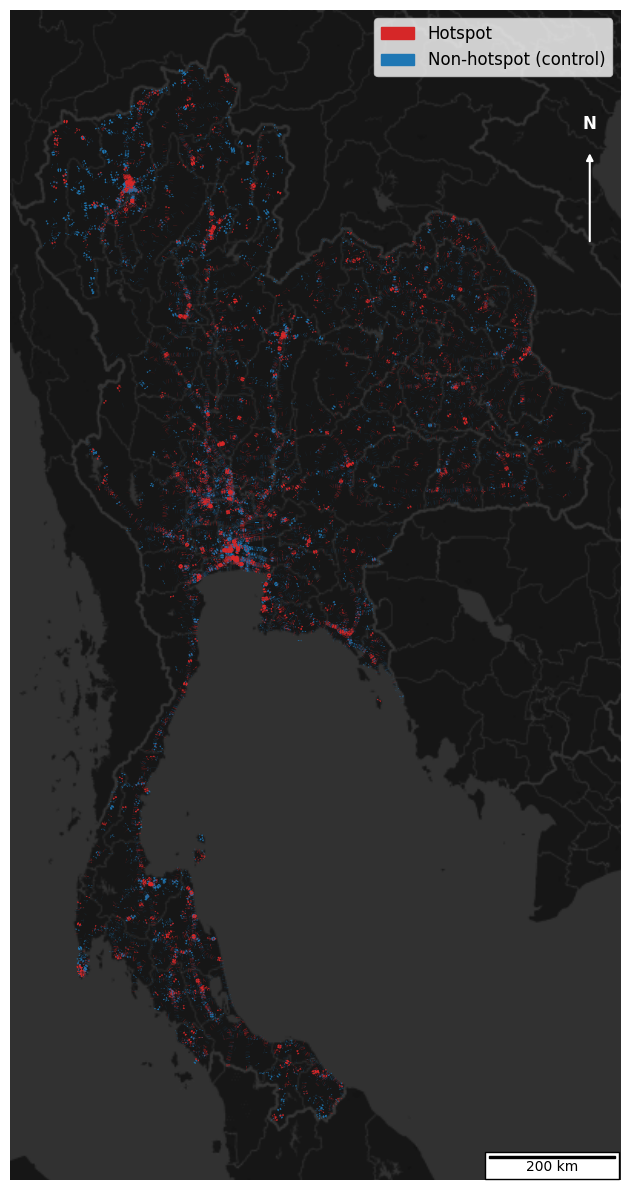

In [21]:
# --- MAP: hotspots vs row-matched non-hotspots ---------------------------
import contextily as ctx
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.font_manager import FontProperties

# ---------- helpers ----------
def _nice_length_m(data_width_m):
    """Pick a nice scalebar length (1/2/5 × 10^n) ~ 1/5 of axis width."""
    target = data_width_m / 5.0
    import math
    exp = int(math.floor(math.log10(target))) if target > 0 else 0
    base = target / (10 ** exp)
    for b in (1, 2, 5, 10):
        if base <= b:
            return b * (10 ** exp)
    return 10 * (10 ** exp)

def add_scalebar(ax, loc="lower left", font_size=9, pad=0.2):
    """Add a scalebar (meters) to an EPSG:3857 axis."""
    xmin, xmax = ax.get_xlim()
    length_m = _nice_length_m(xmax - xmin)
    label = f"{int(length_m/1000)} km" if length_m >= 1000 else f"{int(length_m)} m"
    fp = FontProperties(size=font_size)
    sb = AnchoredSizeBar(ax.transData, length_m, label, loc,
                         pad=pad, color='black', frameon=True,
                         size_vertical=(xmax - xmin) * 0.003,
                         fontproperties=fp)
    ax.add_artist(sb)

def add_north_arrow(ax, xy=(0.8, 0.82), size=0.08, text="N", text_size=10):
    """Add a simple north arrow in axes fraction coords."""
    ax.annotate("", xy=(xy[0], xy[1] + size), xytext=xy,
                xycoords="axes fraction", textcoords="axes fraction",
                arrowprops=dict(arrowstyle="-|>", linewidth=1.5, color="white"))
    ax.text(xy[0], xy[1] + size + 0.015, text,
            transform=ax.transAxes, ha="center", va="bottom",
            fontsize=text_size, fontweight="bold",color="white")

# ---------- DATA EXPECTATIONS ----------
# G: GeoDataFrame of lixels with boolean columns:
#   'is_hot_rows' (hotspots), 'is_ctrl_rows_matched' (row-matched strict non-hot)
# If your column names differ, change below.

hot_col  = "is_hot_rows"
ctrl_col = "is_ctrl_rows_matched"

# Make plotting G from L (hotspots) + C (controls)

# start with all lixels
G = L.copy()

# boolean columns for plotting
G["is_hot_rows"] = G[HOT_FLAG_COL].astype(bool)
G["is_ctrl_rows_matched"] = G.index.isin(C.index)   # mark controls

assert hot_col in G.columns, f"Missing column: {hot_col}"
assert ctrl_col in G.columns, f"Missing column: {ctrl_col}"

# Ensure Web Mercator for basemap
if G.crs is None:
    raise ValueError("G has no CRS. Set G.crs to a projected CRS (e.g., EPSG:3857) before plotting.")
if G.crs.to_epsg() != 3857:
    G = G.to_crs(3857)

# Compute a nice extent with small padding (so scalebar/north arrow don't sit on the edge)
xmin, ymin, xmax, ymax = G.total_bounds
pad_x = (xmax - xmin) * 0.05
pad_y = (ymax - ymin) * 0.05
extent = (xmin - pad_x, xmax + pad_x, ymin - pad_y, ymax + pad_y)

# ---------- PLOT ----------
tiles = ctx.providers.CartoDB.DarkMatterNoLabels  # dark basemap

fig, ax = plt.subplots(figsize=(12, 12))

# Basemap first (zorder low), then lines on top
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ctx.add_basemap(ax, source=tiles, attribution=False, alpha=0.95, zorder=0)

# Non-hotspot controls (below), then hotspots (above) for visibility
G.loc[G[ctrl_col]].plot(ax=ax, color="#1f77b4", linewidth=3, alpha=0.9, zorder=2)  # blue
G.loc[G[hot_col]].plot(ax=ax,  color="#d62728", linewidth=3, alpha=0.95, zorder=3)  # red

# Legend (custom patches so legend order & labels are stable)
legend_handles = [
    mpatches.Patch(color="#d62728", label="Hotspot"),
    mpatches.Patch(color="#1f77b4", label="Non-hotspot (control)"),
]
ax.legend(handles=legend_handles, loc="upper right", fontsize=12, frameon=True)

# Scale bar + north arrow
add_scalebar(ax, loc="lower right", font_size=10, pad=0.3)
add_north_arrow(ax, xy=(0.95, 0.80), size=0.08, text="N", text_size=12)

# Cosmetic
ax.set_axis_off()
fig.tight_layout()

# Save if needed
# fig.savefig("hotspots_vs_controls.png", dpi=300, bbox_inches="tight")
fig.savefig("hotspots_vs_controls.pdf", dpi=300, bbox_inches="tight")

plt.show()


### AADT to lixel (spare)

In [152]:
# 2019-2024 (2562-2567) AADT
# combine aadt/aadt-62.csv - aadt/aadt-67.csv
import pandas as pd
aadt_files = [f"aadt/aadt-{y}.csv" for y in range(62, 68)]
aadt_list = [pd.read_csv(f) for f in aadt_files]
aadt = pd.concat(aadt_list, axis=0)
# aadt = aadt.drop_duplicates(subset=["osm_id"], keep="last").reset_index(drop=True)
# aadt = aadt.rename(columns={"osm_id": "osm_id", "aadt": "aadt_19_24"})

In [153]:
aadt.columns

Index(['ทางหลวงสาย', 'ตอนควบคุม', 'ชื่อสายทาง', 'จุดสำรวจ',
       'รถยนต์นั่ง (ไม่เกิน 7 คน)', 'รถยนต์นั่ง (เกิน 7 คน)',
       'รถโดยสารขนาดเล็ก', 'รถโดยสารขนาดกลาง', 'รถโดยสารขนาดใหญ่',
       '   รถบรรทุกขนาดเล็ก    ( 4 ล้อ)', 'รถบรรทุกขนาด 2 เพลา  (6 ล้อ)',
       '     รถบรรทุกขนาด 3 เพลา (10 ล้อ)',
       '   รถบรรทุกพ่วง  (มากกว่า 3 เพลา)',
       '   รถบรรทุกกึ่งพ่วง (มากกว่า 3 เพลา)', 'รวม', '   % ของยานยนต์หนัก',
       'จักรยาน 2 ล้อ และ จักรยาน 3 ล้อ', 'สามล้อเครื่องและจักรยานยนต์',
       'แขวงทางหลวง', 'จังหวัด', 'รถยนต์นั่ง(ไม่เกิน7คน)',
       'รถยนต์นั่ง(เกิน7คน)', 'รถบรรทุกขนาดเล็ก(4ล้อ)',
       'รถบรรทุกขนาด2เพลา(6ล้อ)', 'รถบรรทุกขนาด3เพลา(10ล้อ)',
       'รถบรรทุกพ่วง(มากกว่า3เพลา)', 'รถบรรทุกกึ่งพ่วง(มากกว่า3เพลา)',
       '%ของยานยนต์หนัก', 'จักรยาน2ล้อและจักรยาน3ล้อ',
       'รถบรรทุกขนาดเล็ก (4 ล้อ)', 'รถบรรทุกขนาด 2 เพลา (6ล้อ)',
       'รถบรรทุกขนาด 3 เพลา (10ล้อ)', 'รถบรรทุกพ่วง (มากกว่า 3 เพลา)',
       'รถบรรทุกกึ่งพ่วง (มากกว่า 3 เพลา)', '% ของยานยนต์หนั

In [ ]:
import re
import numpy as np
import pandas as pd

# 1) Normalize a raw header → compact key (remove spaces/zero-width; unify digits)
THAI_DIGITS = str.maketrans("๐๑๒๓๔๕๖๗๘๙", "0123456789")
def _norm_key(s: str) -> str:
    s = str(s).translate(THAI_DIGITS)
    s = s.replace("\u200b", "").replace("\xa0", "")  # zero-width / non-breaking space
    s = re.sub(r"\s+", "", s)                        # drop all whitespace
    # normalize parentheses spacing variants
    s = s.replace("（", "(").replace("）", ")")
    return s

# 2) Map many variants → one canonical Thai column name
CANON_MAP = {
    _norm_key("ทางหลวงสาย"): "ทางหลวงสาย",
    _norm_key("ตอนควบคุม"): "ตอนควบคุม",
    _norm_key("ชื่อสายทาง"): "ชื่อสายทาง",
    _norm_key("จุดสำรวจ"): "จุดสำรวจ",
    _norm_key("แขวงทางหลวง"): "แขวงทางหลวง",
    _norm_key("จังหวัด"): "จังหวัด",
    _norm_key("รวม"): "รวม",
    _norm_key("% ของยานยนต์หนัก"): "% ของยานยนต์หนัก",
    _norm_key("%ของยานยนต์หนัก"): "% ของยานยนต์หนัก",

    _norm_key("รถยนต์นั่ง (ไม่เกิน 7 คน)"): "รถยนต์นั่ง≤7",
    _norm_key("รถยนต์นั่ง(ไม่เกิน7คน)"): "รถยนต์นั่ง≤7",

    _norm_key("รถยนต์นั่ง (เกิน 7 คน)"): "รถยนต์นั่ง>7",
    _norm_key("รถยนต์นั่ง(เกิน7คน)"): "รถยนต์นั่ง>7",

    _norm_key("รถโดยสารขนาดเล็ก"): "รถโดยสารขนาดเล็ก",
    _norm_key("รถโดยสารขนาดกลาง"): "รถโดยสารขนาดกลาง",
    _norm_key("รถโดยสารขนาดใหญ่"): "รถโดยสารขนาดใหญ่",

    _norm_key("รถบรรทุกขนาดเล็ก (4 ล้อ)"): "รถบรรทุก4ล้อ",
    _norm_key("รถบรรทุกขนาดเล็ก(4ล้อ)"): "รถบรรทุก4ล้อ",
    _norm_key("   รถบรรทุกขนาดเล็ก    ( 4 ล้อ)"): "รถบรรทุก4ล้อ",

    _norm_key("รถบรรทุกขนาด 2 เพลา (6 ล้อ)"): "รถบรรทุก6ล้อ",
    _norm_key("รถบรรทุกขนาด 2 เพลา  (6 ล้อ)"): "รถบรรทุก6ล้อ",
    _norm_key("รถบรรทุกขนาด2เพลา(6ล้อ)"): "รถบรรทุก6ล้อ",
    _norm_key("รถบรรทุกขนาด 2 เพลา (6ล้อ)"): "รถบรรทุก6ล้อ",

    _norm_key("รถบรรทุกขนาด 3 เพลา (10 ล้อ)"): "รถบรรทุก10ล้อ",
    _norm_key("     รถบรรทุกขนาด 3 เพลา (10 ล้อ)"): "รถบรรทุก10ล้อ",
    _norm_key("รถบรรทุกขนาด3เพลา(10ล้อ)"): "รถบรรทุก10ล้อ",
    _norm_key("รถบรรทุกขนาด 3 เพลา (10ล้อ)"): "รถบรรทุก10ล้อ",

    _norm_key("รถบรรทุกพ่วง (มากกว่า 3 เพลา)"): "รถบรรทุกพ่วง",
    _norm_key("   รถบรรทุกพ่วง  (มากกว่า 3 เพลา)"): "รถบรรทุกพ่วง",
    _norm_key("รถบรรทุกพ่วง(มากกว่า3เพลา)"): "รถบรรทุกพ่วง",

    _norm_key("รถบรรทุกกึ่งพ่วง (มากกว่า 3 เพลา)"): "รถบรรทุกกึ่งพ่วง",
    _norm_key("   รถบรรทุกกึ่งพ่วง (มากกว่า 3 เพลา)"): "รถบรรทุกกึ่งพ่วง",
    _norm_key("รถบรรทุกกึ่งพ่วง(มากกว่า3เพลา)"): "รถบรรทุกกึ่งพ่วง",

    _norm_key("จักรยาน 2 ล้อ และ จักรยาน 3 ล้อ"): "จักรยาน2/3ล้อ",
    _norm_key("จักรยาน2ล้อและจักรยาน3ล้อ"): "จักรยาน2/3ล้อ",

    _norm_key("สามล้อเครื่องและจักรยานยนต์"): "มอเตอร์ไซค์",
}

def canonical_name(raw: str) -> str:
    key = _norm_key(raw)
    return CANON_MAP.get(key, raw.strip())

# --- apply: rename & coalesce duplicate columns row-wise ------------------
aadt_clean = aadt.copy()
aadt_clean.columns = [canonical_name(c) for c in aadt_clean.columns]

# Coalesce duplicates by summing across columns with the same name (NaN-safe).
# (In each row only one variant is typically non-null, so sum == the value.)
aadt_clean = aadt_clean.T.groupby(level=0).sum(min_count=1).T

print(aadt_clean.columns.tolist())

# --- Optionally (re)compute 'รวม' if missing or partially empty ----------
vehicle_cols = [c for c in [
    "รถยนต์นั่ง≤7", "รถยนต์นั่ง>7",
    "รถโดยสารขนาดเล็ก", "รถโดยสารขนาดกลาง", "รถโดยสารขนาดใหญ่",
    "รถบรรทุก4ล้อ", "รถบรรทุก6ล้อ", "รถบรรทุก10ล้อ",
    "รถบรรทุกพ่วง", "รถบรรทุกกึ่งพ่วง",
    "จักรยาน2/3ล้อ", "มอเตอร์ไซค์"
] if c in aadt_clean.columns]

if "รวม" not in aadt_clean.columns or aadt_clean["รวม"].isna().all():
    aadt_clean["รวม"] = aadt_clean[vehicle_cols].sum(axis=1, min_count=1)

# Preview
display(aadt_clean.head(3))


['% ของยานยนต์หนัก', 'จักรยาน2/3ล้อ', 'จังหวัด', 'จุดสำรวจ', 'ชื่อสายทาง', 'ตอนควบคุม', 'ทางหลวงสาย', 'มอเตอร์ไซค์', 'รถบรรทุก10ล้อ', 'รถบรรทุก4ล้อ', 'รถบรรทุก6ล้อ', 'รถบรรทุกกึ่งพ่วง', 'รถบรรทุกพ่วง', 'รถยนต์นั่ง>7', 'รถยนต์นั่ง≤7', 'รถโดยสารขนาดกลาง', 'รถโดยสารขนาดเล็ก', 'รถโดยสารขนาดใหญ่', 'รวม', 'แขวงทางหลวง']


,% ของยานยนต์หนัก,จักรยาน2/3ล้อ,จังหวัด,จุดสำรวจ,ชื่อสายทาง,ตอนควบคุม,ทางหลวงสาย,มอเตอร์ไซค์,รถบรรทุก10ล้อ,รถบรรทุก4ล้อ,รถบรรทุก6ล้อ,รถบรรทุกกึ่งพ่วง,รถบรรทุกพ่วง,รถยนต์นั่ง>7,รถยนต์นั่ง≤7,รถโดยสารขนาดกลาง,รถโดยสารขนาดเล็ก,รถโดยสารขนาดใหญ่,รวม,แขวงทางหลวง
0,9.0,8.0,กรุงเทพมหานคร,25+556,แยก คปอ. - สนามกีฬาธูปะเตมีย์,102.0,1.0,10010.0,207.0,17166.0,725.0,83.0,205.0,14241.0,25997.0,1459.0,1183.0,2794.0,64060.0,กรุงเทพ
1,10.0,272.0,ปทุมธานี,35+550,สนามกีฬาธูปะเตมีย์ - ต่างระดับคลองหลวง,201.0,1.0,18925.0,4579.0,68855.0,10403.0,1023.0,1341.0,41847.0,178466.0,4830.0,20795.0,13750.0,345889.0,ปทุมธานี
2,18.0,45.0,พระนครศรีอยุธยา,48+100,ต่างระดับคลองหลวง - ประตูน้ำพระอินทร์,202.0,1.0,13192.0,3508.0,52793.0,17526.0,1464.0,2306.0,38431.0,86604.0,6010.0,3490.0,10115.0,222247.0,ปทุมธานี


In [159]:
print(aadt['ทางหลวงสาย'].nunique())
print(aadt_clean['ทางหลวงสาย'].nunique())

1292
1292


In [160]:
aadt.columns

Index(['ทางหลวงสาย', 'ตอนควบคุม', 'ชื่อสายทาง', 'จุดสำรวจ',
       'รถยนต์นั่ง (ไม่เกิน 7 คน)', 'รถยนต์นั่ง (เกิน 7 คน)',
       'รถโดยสารขนาดเล็ก', 'รถโดยสารขนาดกลาง', 'รถโดยสารขนาดใหญ่',
       '   รถบรรทุกขนาดเล็ก    ( 4 ล้อ)', 'รถบรรทุกขนาด 2 เพลา  (6 ล้อ)',
       '     รถบรรทุกขนาด 3 เพลา (10 ล้อ)',
       '   รถบรรทุกพ่วง  (มากกว่า 3 เพลา)',
       '   รถบรรทุกกึ่งพ่วง (มากกว่า 3 เพลา)', 'รวม', '   % ของยานยนต์หนัก',
       'จักรยาน 2 ล้อ และ จักรยาน 3 ล้อ', 'สามล้อเครื่องและจักรยานยนต์',
       'แขวงทางหลวง', 'จังหวัด', 'รถยนต์นั่ง(ไม่เกิน7คน)',
       'รถยนต์นั่ง(เกิน7คน)', 'รถบรรทุกขนาดเล็ก(4ล้อ)',
       'รถบรรทุกขนาด2เพลา(6ล้อ)', 'รถบรรทุกขนาด3เพลา(10ล้อ)',
       'รถบรรทุกพ่วง(มากกว่า3เพลา)', 'รถบรรทุกกึ่งพ่วง(มากกว่า3เพลา)',
       '%ของยานยนต์หนัก', 'จักรยาน2ล้อและจักรยาน3ล้อ',
       'รถบรรทุกขนาดเล็ก (4 ล้อ)', 'รถบรรทุกขนาด 2 เพลา (6ล้อ)',
       'รถบรรทุกขนาด 3 เพลา (10ล้อ)', 'รถบรรทุกพ่วง (มากกว่า 3 เพลา)',
       'รถบรรทุกกึ่งพ่วง (มากกว่า 3 เพลา)', '% ของยานยนต์หนั

In [161]:
aadt_clean

,% ของยานยนต์หนัก,จักรยาน2/3ล้อ,จังหวัด,จุดสำรวจ,ชื่อสายทาง,ตอนควบคุม,ทางหลวงสาย,มอเตอร์ไซค์,รถบรรทุก10ล้อ,รถบรรทุก4ล้อ,รถบรรทุก6ล้อ,รถบรรทุกกึ่งพ่วง,รถบรรทุกพ่วง,รถยนต์นั่ง>7,รถยนต์นั่ง≤7,รถโดยสารขนาดกลาง,รถโดยสารขนาดเล็ก,รถโดยสารขนาดใหญ่,รวม,แขวงทางหลวง
0,9.0,8.0,กรุงเทพมหานคร,25+556,แยก คปอ. - สนามกีฬาธูปะเตมีย์,102.0,1.0,10010.0,207.0,17166.0,725.0,83.0,205.0,14241.0,25997.0,1459.0,1183.0,2794.0,64060.0,กรุงเทพ
1,10.0,272.0,ปทุมธานี,35+550,สนามกีฬาธูปะเตมีย์ - ต่างระดับคลองหลวง,201.0,1.0,18925.0,4579.0,68855.0,10403.0,1023.0,1341.0,41847.0,178466.0,4830.0,20795.0,13750.0,345889.0,ปทุมธานี
2,18.0,45.0,พระนครศรีอยุธยา,48+100,ต่างระดับคลองหลวง - ประตูน้ำพระอินทร์,202.0,1.0,13192.0,3508.0,52793.0,17526.0,1464.0,2306.0,38431.0,86604.0,6010.0,3490.0,10115.0,222247.0,ปทุมธานี
3,35.0,0.0,พระนครศรีอยุธยา,60+800,ประตูน้ำพระอินทร์ - หนองแค,300.0,1.0,2275.0,9374.0,12578.0,11569.0,7863.0,8355.0,25502.0,37908.0,2814.0,7881.0,5757.0,129601.0,อยุธยา
4,40.0,0.0,พระนครศรีอยุธยา,67+300,ประตูน้ำพระอินทร์ - หนองแค,300.0,1.0,2058.0,10719.0,16887.0,16192.0,9519.0,10756.0,21076.0,39620.0,2136.0,8274.0,6972.0,142151.0,อยุธยา
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4861,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4862,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4863,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4864,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [134]:
# === AADT CSVs (2019–2024) → per-route mean → attach to lixels by ref =====
import re, os, glob
import numpy as np
import pandas as pd

# Paths & columns
AADT_GLOB   = "aadt/aadt-*.csv"        # expects ...-62.csv .. -67.csv
ROUTE_COL   = "ทางหลวงสาย"
KMPOINT_COL = "จุดสำรวจ"               # optional (we parse but don't need it for route-level mean)
PERCENT_HINTS = ["%", "เปอร์เซ็น"]      # columns containing these are excluded from part-sums

# Buddhist year file name map (…-62.csv → 2019 CE)
YEAR_MAP = {62: 2019, 63: 2020, 64: 2021, 65: 2022, 66: 2023, 67: 2024}

THAI_DIGITS = str.maketrans("๐๑๒๓๔๕๖๗๘๙", "0123456789")

def try_read_csv(path):
    for enc in ("utf-8-sig", "utf-8", "cp874"):
        try:
            return pd.read_csv(path, encoding=enc, low_memory=False)
        except Exception:
            pass
    return pd.read_csv(path, low_memory=False)

def coerce_numeric(s: pd.Series) -> pd.Series:
    return (s.astype(str)
              .str.translate(THAI_DIGITS)
              .str.replace(",", "", regex=False)
              .str.replace(" ", "", regex=False)
              .str.replace("\u200b", "", regex=False)
              .replace({"": np.nan, "nan": np.nan, "None": np.nan})
              .astype(float))

def parse_km_text(s):
    if s is None or (isinstance(s, float) and np.isnan(s)): 
        return np.nan
    s0 = str(s).strip().translate(THAI_DIGITS)
    s0 = s0.replace("กม.", "").replace("กม", "").strip()
    m = re.search(r"(\d+)\s*\+\s*(\d+)", s0)
    if m:
        return int(m.group(1))*1000 + int(m.group(2))
    m2 = re.search(r"(\d+(?:\.\d+)?)", s0)
    return float(m2.group(1))*1000 if m2 else np.nan

def normalize_osm_ref(ref):
    if ref is None or (isinstance(ref, float) and np.isnan(ref)): return None
    s = str(ref).translate(THAI_DIGITS)
    toks = re.split(r"[;,\s/]+", s.strip())
    for t in toks:
        m = re.fullmatch(r"[Mm](\d+)", t)
        if m: return f"M{m.group(1)}"
    for t in toks:
        if re.fullmatch(r"\d{1,4}", t): return t
    return toks[0] if toks else None

def normalize_route_value(x):
    # from '1', 'ทล.1', 'ทางหลวงสาย 1' → '1'
    s = str(x).translate(THAI_DIGITS)
    m = re.search(r"(\d{1,4})", s)
    return m.group(1) if m else np.nan

def year_from_filename(path):
    m = re.search(r"(\d{2})(?=\.csv$)", os.path.basename(path))
    if not m: return np.nan
    return YEAR_MAP.get(int(m.group(1)), np.nan)

# --- load & harmonize all years ------------------------------------------
rows = []
bad_files = []

for path in sorted(glob.glob(AADT_GLOB)):
    df = try_read_csv(path)
    yr = year_from_filename(path)
    if pd.isna(yr) or df.empty:
        bad_files.append((path, "empty or no year match"))
        continue

    # ensure ROUTE_COL exists
    if ROUTE_COL not in df.columns:
        bad_files.append((path, f"missing '{ROUTE_COL}'"))
        continue

    # route id → string token
    route_norm = df[ROUTE_COL].astype(str).map(normalize_route_value)

    # find 'รวม' column if present (exact match)
    total_col = None
    for c in df.columns:
        if str(c).strip() == "รวม":
            total_col = c
            break

    # build numeric view for possible part-sum
    num_df = pd.DataFrame(index=df.index)
    for c in df.columns:
        # skip obvious non-traffic descriptors
        if c in [ROUTE_COL, KMPOINT_COL, "ตอนควบคุม", "ชื่อสายทาง", "แขวงทางหลวง", "จังหวัด"]:
            continue
        # skip percent-like cols by header hint
        cname = str(c)
        if any(h in cname for h in PERCENT_HINTS):
            continue
        # attempt numeric
        num_df[c] = coerce_numeric(df[c])

    # parts sum (exclude 'รวม' itself to avoid double counting)
    part_cols = [c for c in num_df.columns if c != total_col]
    parts_sum = num_df[part_cols].sum(axis=1, min_count=1)

    # preferred AADT = 'รวม' if present & numeric else parts sum
    if total_col is not None:
        total_clean = coerce_numeric(df[total_col])
        aadt_val = total_clean.where(~total_clean.isna(), parts_sum)
    else:
        aadt_val = parts_sum

    # optional: parse km for future refinement (not needed for route-avg)
    km_m = df[KMPOINT_COL].map(parse_km_text) if KMPOINT_COL in df.columns else np.nan

    out = pd.DataFrame({
        "year": yr,
        "route_norm": route_norm,
        "aadt": aadt_val,
        "km_m": km_m
    })
    # keep only rows with route & aadt
    out = out.dropna(subset=["route_norm", "aadt"])
    rows.append(out)

if not rows:
    raise RuntimeError(f"No usable rows loaded. Problems: {bad_files[:3]} ...")

aadt_all = pd.concat(rows, ignore_index=True)
print(f"Loaded AADT rows: {len(aadt_all):,} from files: {sorted(set(aadt_all['year']))}")

# --- per-route per-year mean, then 2019–2024 mean -------------------------
aadt_route_year = (aadt_all.groupby(["route_norm","year"])["aadt"]
                            .mean()
                            .rename("aadt_route_mean")
                            .reset_index())

aadt_route_2019_2024 = (aadt_route_year.groupby("route_norm")["aadt_route_mean"]
                                      .mean()
                                      .rename("aadt_2019_2024_mean")
                                      .reset_index())

print(f"Routes with AADT (2019–2024 mean): {len(aadt_route_2019_2024):,}")

# --- attach to your lixels by OSM ref ------------------------------------
L_with_ref = G_all.copy()
L_with_ref["ref_norm"] = L_with_ref["ref"].map(normalize_osm_ref)
L_with_ref = L_with_ref.merge(aadt_route_2019_2024, left_on="ref_norm", right_on="route_norm", how="left")
L_with_ref = L_with_ref.drop(columns=["route_norm"])

print(f"Lixels with route-level AADT attached: {(~L_with_ref['aadt_2019_2024_mean'].isna()).sum():,} / {len(L_with_ref):,}")

# Optional: keep a minimal output
L_aadt_min = L_with_ref[["geometry", "ref_norm",'ref' ,"density_bw200", "label", "aadt_2019_2024_mean",]].copy()


Loaded AADT rows: 16,257 from files: [2019, 2020, 2021, 2022, 2023, 2024]
Routes with AADT (2019–2024 mean): 1,292
Lixels with route-level AADT attached: 673,234 / 1,340,313


In [157]:
aadt_route_2019_2024

,route_key,aadt_2019_2024_mean
0,1,35912.501089
1,1001,18802.833333
2,1004,10841.333333
3,1006,23764.916667
4,1007,13498.333333
...,...,...
1287,4353,618.800000
1288,4363,421.000000
1289,44,8786.611111
1290,7,88279.378788


In [135]:
L_aadt_min

,geometry,ref_norm,ref,density_bw200,label,aadt_2019_2024_mean
0,"LINESTRING (11192236.42 1557769.067, 11192215....",302,302,0.000000,nonhot_strict,121114.666667
1,"LINESTRING (11170509.06 1902991.283, 11170608....",126,126,0.000000,nonhot_strict,19608.333333
2,"LINESTRING (11170608.138 1902956.675, 11170672...",126,126,0.000000,nonhot_strict,19608.333333
3,"LINESTRING (11170706.573 1902920.34, 11170730....",126,126,0.000000,nonhot_strict,19608.333333
4,"LINESTRING (11170802.355 1902877.662, 11170892...",126,126,0.000000,nonhot_strict,19608.333333
...,...,...,...,...,...,...
1340308,"LINESTRING (11259808.921 1457885.804, 11259812...",None,None,0.000315,hotspot,NaN
1340309,"LINESTRING (11177626.806 1546016.517, 11177615...",None,None,0.000000,nonhot_strict,NaN
1340310,"LINESTRING (11422953.501 1815331.71, 11422956....",None,None,0.000230,hotspot,NaN
1340311,"LINESTRING (10943508.514 904836.872, 10943521....",None,None,0.000000,control,NaN


In [136]:
# --- drop-in fixes for provincial refs like 'ชม.3029' --------------------
def route_key(text):
    """
    Canonicalize a route/ref string to one of:
      - 'M7'               (motorways)
      - '1', '304'         (national highways)
      - 'ชม.3029'          (provincial: Thai prefix + '.' + digits)
    Works for OSM 'ref' and AADT 'ทางหลวงสาย'.
    """
    if text is None or (isinstance(text, float) and np.isnan(text)):
        return None
    s = str(text).translate(THAI_DIGITS)
    # remove spaces; split on common separators; try each token
    tokens = re.split(r"[;,\s/|]+", s.strip())
    for tok in tokens:
        if not tok:
            continue
        t = tok.replace("ทางหลวงหมายเลข", "").replace("ทล.", "").replace("หมายเลข", "")
        t = re.sub(r"\s+", "", t)

        # 1) Motorways: M7, m9, etc.
        m = re.fullmatch(r"[Mm](\d{1,4})", t)
        if m:
            return f"M{int(m.group(1))}"

        # 2) Provincial roads: Thai letters + optional dot + digits, e.g. ชม.3029 / ชม3029
        m = re.fullmatch(r"([ก-๙]{1,3})\.?(\d{1,4})", t)
        if m:
            return f"{m.group(1)}.{int(m.group(2))}"

        # 3) Plain digits: national highways (1..4 digits)
        m = re.fullmatch(r"(\d{1,4})", t)
        if m:
            return m.group(1)

        # 4) Fallbacks: search inside the token for patterns
        m = re.search(r"([ก-๙]{1,3})\.?(\d{1,4})", t)
        if m:
            return f"{m.group(1)}.{int(m.group(2))}"
        m = re.search(r"(\d{1,4})", t)
        if m:
            return m.group(1)

    return None


In [137]:
# route id → canonical key (handles M7, 1, ชม.3029, etc.)
route_norm = df[ROUTE_COL].map(route_key)


In [138]:
L_with_ref = L.copy()
L_with_ref["route_key"] = L_with_ref["ref"].map(route_key)

aadt_route_2019_2024 = aadt_route_2019_2024.rename(columns={"route_norm": "route_key"})
L_with_ref = L_with_ref.merge(aadt_route_2019_2024, on="route_key", how="left")


In [139]:
unmatched = (L_with_ref[L_with_ref["aadt_2019_2024_mean"].isna()]
             ["route_key"].value_counts().head(20))
print("Top unmatched route keys:\n", unmatched)


Top unmatched route keys:
 route_key
ถ.1        4905
สส.2021    1767
นบ.3021    1262
59         1037
รย.4036     991
ชร.3037     984
มส.4009     965
4004        960
58          933
31          846
ชร.1063     805
อบ.3150     763
ตก.3054     725
นม.3052     695
ชม.4016     695
กจ.4004     686
นย.3001     671
กจ.6093     662
พล.2036     659
กส.4073     642
Name: count, dtype: int64


In [143]:
import re
import numpy as np
import pandas as pd

THAI_DIGITS = str.maketrans("๐๑๒๓๔๕๖๗๘๙", "0123456789")

def route_key(text):
    """
    Canonical key for routes:
      - 'M7' for motorways,
      - '1','304' for national,
      - 'ชม.3029' for rural/provincial (Thai prefix + '.' + digits).
    Strips descriptors like 'ถ.', 'ถนน', 'ทล.', 'ทช.', 'AH', etc.
    """
    if text is None or (isinstance(text, float) and pd.isna(text)):
        return None
    s = str(text).translate(THAI_DIGITS)
    s = (s.replace("ทางหลวงหมายเลข", "")
           .replace("ทางหลวงพิเศษหมายเลข", "")
           .replace("ทางหลวงชนบท", "")
           .replace("ถนน", "")
           .replace("ทช.", "")
           .replace("ทล.", "")
           .replace("หมายเลข", "")
           .replace("AH", ""))
    tokens = re.split(r"[;,\s/|]+", s.strip())
    for tok in tokens:
        if not tok:
            continue
        t = tok.strip()
        m = re.fullmatch(r"ถ\.(\d{1,4})", t)             # ถ.1 → 1
        if m: return m.group(1)
        m = re.fullmatch(r"[Mm](\d{1,4})", t)             # M7
        if m: return f"M{int(m.group(1))}"
        m = re.fullmatch(r"([ก-๙]{1,3})\.?(\d{1,4})", t)  # ชม.3029 or ชม3029
        if m: return f"{m.group(1)}.{int(m.group(2))}"
        m = re.fullmatch(r"(\d{1,4})", t)                 # 1..4 digits
        if m: return m.group(1)
        m = re.search(r"([ก-๙]{1,3})\.?(\d{1,4})", t)     # fallback inside token
        if m: return f"{m.group(1)}.{int(m.group(2))}"
        m = re.search(r"(\d{1,4})", t)
        if m: return m.group(1)
    return None

def route_num_key(text):
    """
    Numeric-only fallback key:
      - Motorways keep 'M#' (so 'M7' ≠ '7'),
      - Provincial/national return just the digits, e.g. 'ชม.3029' → '3029', '1' → '1'.
    """
    k = route_key(text)
    if k is None:
        return None
    if re.fullmatch(r"M\d{1,4}", k):          # keep motorways distinct
        return k
    m = re.fullmatch(r"([ก-๙]{1,3})\.(\d{1,4})", k)
    if m:
        return m.group(2)                     # drop Thai prefix
    return k                                   # already digits like '1','304'

# --- Build route-level (full key) means per year, then 2019–2024 mean ----
aadt_all = aadt_all.copy()
aadt_all["route_key"] = aadt_all["route_norm"].map(route_key)
full_year = (aadt_all.dropna(subset=["route_key"])
                      .groupby(["route_key","year"])["aadt"].mean().rename("aadt_mean").reset_index())
aadt_full_2019_2024 = (full_year.groupby("route_key")["aadt_mean"]
                                .mean().rename("aadt_2019_2024_mean").reset_index())

# --- Build numeric-only fallback means -----------------------------------
aadt_all["route_num"] = aadt_all["route_norm"].map(route_num_key)
num_year = (aadt_all.dropna(subset=["route_num"])
                     .groupby(["route_num","year"])["aadt"].mean().rename("aadt_mean").reset_index())
aadt_num_2019_2024 = (num_year.groupby("route_num")["aadt_mean"]
                               .mean().rename("aadt_2019_2024_mean_num").reset_index())

print(f"Route keys (full) with means: {len(aadt_full_2019_2024):,}")
print(f"Route keys (numeric) with means: {len(aadt_num_2019_2024):,}")

# --- Attach to lixels: full key first, then numeric fallback -------------
L_with_ref = L.copy()
L_with_ref["route_key"] = L_with_ref["ref"].map(route_key)
L_with_ref["route_num"] = L_with_ref["ref"].map(route_num_key)

# Full match
L_with_ref = L_with_ref.merge(aadt_full_2019_2024, on="route_key", how="left")

matched_full = (~L_with_ref["aadt_2019_2024_mean"].isna()).sum()

# Fallback by numeric (only where still NaN)
L_with_ref = L_with_ref.merge(aadt_num_2019_2024, on="route_num", how="left")
L_with_ref["aadt_2019_2024_mean"] = L_with_ref["aadt_2019_2024_mean"] \
    .fillna(L_with_ref["aadt_2019_2024_mean_num"])

matched_total = (~L_with_ref["aadt_2019_2024_mean"].isna()).sum()

print(f"Matched by full key: {matched_full:,}/{len(L_with_ref):,}")
print(f"Matched after numeric fallback: {matched_total:,}/{len(L_with_ref):,}")

# Debug top remaining unmatched keys
rem = L_with_ref[L_with_ref["aadt_2019_2024_mean"].isna()]
print("Top unmatched (by full key):")
print(rem["route_key"].value_counts().head(15))
print("\nTop unmatched (by numeric fallback):")
print(rem["route_num"].value_counts().head(15))

# Minimal output if you want it
L_aadt_min = L_with_ref[["geometry", "ref", "route_key", "route_num",
                         "density_bw200", "is_hot", "aadt_2019_2024_mean"]].copy()


Route keys (full) with means: 1,292
Route keys (numeric) with means: 1,292
Matched by full key: 679,630/1,340,313
Matched after numeric fallback: 1,006,148/1,340,313
Top unmatched (by full key):
route_key
นบ.3021    1262
59         1037
รย.4036     991
ชร.3037     984
4004        960
58          933
31          846
อบ.3150     763
ตก.3054     725
กจ.4004     686
นย.3001     671
กจ.6093     662
พล.2036     659
กส.4073     642
มส.4044     596
Name: count, dtype: int64

Top unmatched (by numeric fallback):
route_num
4004    6167
4007    5419
4017    4952
3003    4710
3009    4497
3001    4155
3002    4123
3023    4083
3021    3971
3007    3942
3012    3930
3015    3882
3018    3360
4036    3352
4005    3326
Name: count, dtype: int64


In [150]:
L_aadt_min

,geometry,ref,route_key,route_num,density_bw200,is_hot,aadt_2019_2024_mean
0,"LINESTRING (11192236.42 1557769.067, 11192215....",302,302,302,0.000000,False,121114.666667
1,"LINESTRING (11170509.06 1902991.283, 11170608....",126,126,126,0.000000,False,19608.333333
2,"LINESTRING (11170608.138 1902956.675, 11170672...",126,126,126,0.000000,False,19608.333333
3,"LINESTRING (11170706.573 1902920.34, 11170730....",126,126,126,0.000000,False,19608.333333
4,"LINESTRING (11170802.355 1902877.662, 11170892...",126,126,126,0.000000,False,19608.333333
...,...,...,...,...,...,...,...
1340308,"LINESTRING (11259808.921 1457885.804, 11259812...",None,None,None,0.000315,True,NaN
1340309,"LINESTRING (11177626.806 1546016.517, 11177615...",None,None,None,0.000000,False,NaN
1340310,"LINESTRING (11422953.501 1815331.71, 11422956....",None,None,None,0.000230,True,NaN
1340311,"LINESTRING (10943508.514 904836.872, 10943521....",None,None,None,0.000000,False,NaN


In [151]:
aadt

,ทางหลวงสาย,ตอนควบคุม,ชื่อสายทาง,จุดสำรวจ,รถยนต์นั่ง (ไม่เกิน 7 คน),รถยนต์นั่ง (เกิน 7 คน),รถโดยสารขนาดเล็ก,รถโดยสารขนาดกลาง,รถโดยสารขนาดใหญ่,รถบรรทุกขนาดเล็ก ( 4 ล้อ),รถบรรทุกขนาด 2 เพลา (6 ล้อ),รถบรรทุกขนาด 3 เพลา (10 ล้อ),รถบรรทุกพ่วง (มากกว่า 3 เพลา),รถบรรทุกกึ่งพ่วง (มากกว่า 3 เพลา),รวม,% ของยานยนต์หนัก,จักรยาน 2 ล้อ และ จักรยาน 3 ล้อ,สามล้อเครื่องและจักรยานยนต์,แขวงทางหลวง,จังหวัด
0,1,102,แยก คปอ. - สนามกีฬาธูปะเตมีย์,25+556,25997,14241,1183,1459,2794,17166,725,207,205,83,64060,9,8,10010,กรุงเทพ,กรุงเทพมหานคร
1,1,201,สนามกีฬาธูปะเตมีย์ - ต่างระดับคลองหลวง,35+550,178466,41847,20795,4830,13750,68855,10403,4579,1341,1023,345889,10,272,18925,ปทุมธานี,ปทุมธานี
2,1,202,ต่างระดับคลองหลวง - ประตูน้ำพระอินทร์,48+100,86604,38431,3490,6010,10115,52793,17526,3508,2306,1464,222247,18,45,13192,ปทุมธานี,พระนครศรีอยุธยา
3,1,300,ประตูน้ำพระอินทร์ - หนองแค,60+800,37908,25502,7881,2814,5757,12578,11569,9374,8355,7863,129601,35,0,2275,อยุธยา,พระนครศรีอยุธยา
4,1,300,ประตูน้ำพระอินทร์ - หนองแค,67+300,39620,21076,8274,2136,6972,16887,16192,10719,10756,9519,142151,40,0,2058,อยุธยา,พระนครศรีอยุธยา
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,4347,100,ตลาดฉุ้น - บ้านซา,0+400,414,108,7,7,0,413,46,4,0,0,999,6,7,541,ตรัง,ตรัง
2696,4348,100,ห้วยเจ - ควนอารีย์,1+500,139,78,2,0,0,898,19,19,0,0,1155,3,2,866,กระบี่,ตรัง
2697,4349,100,เขาดิน - บางปอ,1+000,400,275,1,0,0,1010,93,66,18,8,1871,10,36,762,สุราษฎร์ธานีที่ 1,สุราษฎร์ธานี
2698,4350,100,แหลมยาง - หาดผก,0+100,138,45,3,0,0,208,5,2,2,0,403,2,0,268,สุราษฎร์ธานีที่ 2 (กาญจนดิษฐ์),สุราษฎร์ธานี


In [146]:
L_aadt_min['route_num'].nunique()

2097

In [147]:
aadt['ทางหลวงสาย'].nunique()

1260

In [145]:
aadt['ทางหลวงสาย'].unique()
# L_aadt_min['route_key'].unique()

array([   1,    2,    3, ..., 4349, 4350, 4363])

In [86]:
aadt_route_2019_2024

,route_norm,aadt_2019_2024_mean
0,1,35912.501089
1,1001,18802.833333
2,1004,10841.333333
3,1006,23764.916667
4,1007,13498.333333
...,...,...
1287,4353,618.800000
1288,4363,421.000000
1289,44,8786.611111
1290,7,88279.378788


# AADT

In [162]:
# === AADT (2019–2024) -> keep only "รวม" and "มอเตอร์ไซค์", attach to OSM ===
import os, glob, re
import numpy as np
import pandas as pd

# ---- config ----
AADT_GLOB   = "aadt/aadt-*.csv"         # files ...-62.csv .. -67.csv (B.E.)
YEAR_MAP    = {62:2019, 63:2020, 64:2021, 65:2022, 66:2023, 67:2024}
ROUTE_COL   = "ทางหลวงสาย"

# ---- helpers ----
THAI_DIGITS = str.maketrans("๐๑๒๓๔๕๖๗๘๙", "0123456789")

def try_read_csv(path):
    for enc in ("utf-8-sig", "utf-8", "cp874"):
        try: return pd.read_csv(path, encoding=enc, low_memory=False)
        except Exception: pass
    return pd.read_csv(path, low_memory=False)

def coerce_numeric(s: pd.Series) -> pd.Series:
    return (s.astype(str)
             .str.translate(THAI_DIGITS)
             .str.replace(",", "", regex=False)
             .str.replace(" ", "", regex=False)
             .str.replace("\u200b", "", regex=False)
             .replace({"": np.nan, "nan": np.nan, "None": np.nan})
             .astype(float))

def _norm_key(s: str) -> str:
    s = str(s).translate(THAI_DIGITS)
    s = s.replace("\u200b", "").replace("\xa0", "")
    s = re.sub(r"\s+", "", s)
    s = s.replace("（","(").replace("）",")")
    return s

# collapse header variants → canonical names (we only keep 3)
CANON_MAP = {
    _norm_key("ทางหลวงสาย"): "ทางหลวงสาย",
    _norm_key("รวม"): "รวม",
    _norm_key("% ของยานยนต์หนัก"): "% ของยานยนต์หนัก",
    _norm_key("%ของยานยนต์หนัก"): "% ของยานยนต์หนัก",
    # motorcycle column variants → "มอเตอร์ไซค์"
    _norm_key("สามล้อเครื่องและจักรยานยนต์"): "มอเตอร์ไซค์",
    _norm_key("จักรยานยนต์"): "มอเตอร์ไซค์",
    _norm_key("รถจักรยานยนต์"): "มอเตอร์ไซค์",
}

def canonical_name(raw: str) -> str:
    key = _norm_key(raw)
    return CANON_MAP.get(key, raw.strip())

def year_from_filename(path):
    m = re.search(r"(\d{2})(?=\.csv$)", os.path.basename(path))
    return YEAR_MAP.get(int(m.group(1))) if m else None

def route_key(text):
    """
    Canonical route id:
      - 'M7' (motorway),
      - '1','304' (national),
      - 'ชม.3029' (provincial/rural: Thai prefix + '.' + digits).
    Strips descriptors like 'ถ.', 'ถนน', 'ทล.', 'ทช.', 'AH', etc.
    """
    if text is None or (isinstance(text, float) and pd.isna(text)): return None
    s = str(text).translate(THAI_DIGITS)
    s = (s.replace("ทางหลวงหมายเลข","")
           .replace("ทางหลวงพิเศษหมายเลข","")
           .replace("ทางหลวงชนบท","")
           .replace("ถนน","")
           .replace("ทช.","").replace("ทล.","")
           .replace("หมายเลข","")
           .replace("AH",""))
    toks = re.split(r"[;,\s/|]+", s.strip())
    for tok in toks:
        if not tok: continue
        t = tok.strip()
        m = re.fullmatch(r"ถ\.(\d{1,4})", t)          # ถ.1 -> 1
        if m: return m.group(1)
        m = re.fullmatch(r"[Mm](\d{1,4})", t)          # M7
        if m: return f"M{int(m.group(1))}"
        m = re.fullmatch(r"([ก-๙]{1,3})\.?(\d{1,4})", t)  # ชม.3029 or ชม3029
        if m: return f"{m.group(1)}.{int(m.group(2))}"
        m = re.fullmatch(r"(\d{1,4})", t)              # 1..4
        if m: return m.group(1)
        m = re.search(r"([ก-๙]{1,3})\.?(\d{1,4})", t)
        if m: return f"{m.group(1)}.{int(m.group(2))}"
        m = re.search(r"(\d{1,4})", t)
        if m: return m.group(1)
    return None

def route_num_key(text):
    """Numeric fallback: keep 'M#' distinct; drop provincial prefix else."""
    k = route_key(text)
    if k is None: return None
    if re.fullmatch(r"M\d{1,4}", k): return k
    m = re.fullmatch(r"([ก-๙]{1,3})\.(\d{1,4})", k)
    return m.group(2) if m else k

# ---- load & keep only the columns we care about --------------------------
rows = []
for path in sorted(glob.glob(AADT_GLOB)):
    df = try_read_csv(path)
    if df.empty: 
        print(f"[WARN] empty: {path}"); 
        continue
    df = df.rename(columns=lambda c: canonical_name(c))
    if ROUTE_COL not in df.columns:
        print(f"[SKIP] {path} missing '{ROUTE_COL}'"); 
        continue

    # keep only needed cols (+ we drop the % column)
    keep = [c for c in [ROUTE_COL, "รวม", "มอเตอร์ไซค์"] if c in df.columns]
    df = df[keep].copy()
    if "รวม" in df: df["รวม"] = coerce_numeric(df["รวม"])
    if "มอเตอร์ไซค์" in df: df["มอเตอร์ไซค์"] = coerce_numeric(df["มอเตอร์ไซค์"])

    # identify year
    yr = year_from_filename(path)
    if yr is None: 
        print(f"[SKIP] no year parse: {path}"); 
        continue
    df["year"] = yr

    # route keys
    df["route_key"] = df[ROUTE_COL].map(route_key)
    df["route_num"] = df[ROUTE_COL].map(route_num_key)

    # drop rows with no route key and no values
    if "รวม" not in df: df["รวม"] = np.nan
    if "มอเตอร์ไซค์" not in df: df["มอเตอร์ไซค์"] = np.nan
    df = df.dropna(subset=["route_key"], how="all")
    if df[["รวม","มอเตอร์ไซค์"]].isna().all(axis=None):
        continue

    rows.append(df[[ "route_key","route_num","year","รวม","มอเตอร์ไซค์" ]])

if not rows:
    raise RuntimeError("No usable AADT rows found.")

aadt_all = pd.concat(rows, ignore_index=True)
print(f"Loaded rows: {len(aadt_all):,} years={sorted(aadt_all['year'].unique())}")

# ---- per route-year means, then 2019–2024 mean (full key) ---------------
agg_full = (aadt_all.dropna(subset=["route_key"])
                     .groupby(["route_key","year"])[["รวม","มอเตอร์ไซค์"]]
                     .mean()
                     .reset_index())
mean_full = (agg_full.groupby("route_key")[["รวม","มอเตอร์ไซค์"]]
                     .mean()
                     .rename(columns={"รวม":"รวม_2019_2024_mean", "มอเตอร์ไซค์":"มอเตอร์ไซค์_2019_2024_mean"})
                     .reset_index())

# ---- numeric-only fallback ----------------------------------------------
agg_num = (aadt_all.dropna(subset=["route_num"])
                   .groupby(["route_num","year"])[["รวม","มอเตอร์ไซค์"]]
                   .mean()
                   .reset_index())
mean_num = (agg_num.groupby("route_num")[["รวม","มอเตอร์ไซค์"]]
                   .mean()
                   .rename(columns={"รวม":"รวม_2019_2024_mean_num", "มอเตอร์ไซค์":"มอเตอร์ไซค์_2019_2024_mean_num"})
                   .reset_index())

# ---- pick your lixel GeoDataFrame ---------------------------------------
base = None
for cand in ["G_all","L","lixels_100"]:
    if cand in globals():
        base = globals()[cand].copy()
        break
if base is None:
    raise RuntimeError("Could not find a lixel GeoDataFrame (tried G_all, L, lixels_100).")

# ---- attach to lixels: full key first, then numeric fallback ------------
base["route_key"] = base["ref"].map(route_key)
base["route_num"] = base["ref"].map(route_num_key)

out = base.merge(mean_full, on="route_key", how="left")
matched_full = out["รวม_2019_2024_mean"].notna().sum()

out = out.merge(mean_num, on="route_num", how="left")
for col in ["รวม","มอเตอร์ไซค์"]:
    out[f"{col}_2019_2024_mean"] = out[f"{col}_2019_2024_mean"] \
        .fillna(out[f"{col}_2019_2024_mean_num"])
    out.drop(columns=[f"{col}_2019_2024_mean_num"], inplace=True, errors="ignore")

matched_total = out["รวม_2019_2024_mean"].notna().sum()
print(f"Matched by full key: {matched_full:,}/{len(out):,}")
print(f"Matched after numeric fallback: {matched_total:,}/{len(out):,}")

# ---- minimal output with just what you want ------------------------------
keep_cols = ["geometry","ref","route_key","route_num"]
if "density_bw200" in out.columns: keep_cols.append("density_bw200")
if "label" in out.columns: keep_cols.append("label")
elif "is_hot" in out.columns: keep_cols.append("is_hot")

keep_cols += ["รวม_2019_2024_mean","มอเตอร์ไซค์_2019_2024_mean"]
L_aadt_min = out[keep_cols].copy()

print(L_aadt_min.head(2))


[SKIP] no year parse: aadt/aadt-60.csv
[SKIP] no year parse: aadt/aadt-61.csv
Loaded rows: 16,257 years=[2019, 2020, 2021, 2022, 2023, 2024]
Matched by full key: 679,630/1,340,313
Matched after numeric fallback: 1,006,148/1,340,313
                                            geometry  ref route_key route_num  \
0  LINESTRING (11192236.42 1557769.067, 11192215....  302       302       302   
1  LINESTRING (11170509.06 1902991.283, 11170608....  126       126       126   

   density_bw200          label  รวม_2019_2024_mean  \
0            0.0  nonhot_strict       121114.666667   
1            0.0  nonhot_strict        19608.333333   

   มอเตอร์ไซค์_2019_2024_mean  
0                20938.083333  
1                 2404.291667  


In [ ]:
L_aadt_min['label'].unique() # hotspot, control

['nonhot_strict', 'control', 'nonhot_near_hot', 'hotspot']
Categories (4, object): ['hotspot', 'control', 'nonhot_strict', 'nonhot_near_hot']

In [172]:
# how many is NAN of label = control and control
print("all control missing:", L_aadt_min[L_aadt_min['label']=='control']['รวม_2019_2024_mean'].isna().sum())
print("all hotspot missing:", L_aadt_min[L_aadt_min['label']=='hotspot']['รวม_2019_2024_mean'].isna().sum())
print("motorcycle control missing:", L_aadt_min[L_aadt_min['label']=='control']['มอเตอร์ไซค์_2019_2024_mean'].isna().sum())
print("motorcycle hotspot missing:", L_aadt_min[L_aadt_min['label']=='hotspot']['มอเตอร์ไซค์_2019_2024_mean'].isna().sum())


all control missing: 2798
all hotspot missing: 2644
motorcycle control missing: 2798
motorcycle hotspot missing: 2644


In [171]:
# save L_aadt_min
L_aadt_min.to_file("roadnetwork/lixels_with_aadt.geojson", driver="GeoJSON")


In [3]:
import geopandas as gpd

L_aadt_min = gpd.read_file("roadnetwork/lixels_with_aadt.geojson")

In [174]:
!pip install jenkspy

In [ ]:
# # classify รวม_2019_2024_mean and มอเตอร์ไซค์_2019_2024_mean -- 5 levels using jenks, ignoring 0
# import jenkspy

# def jenks_breaks(data, n_classes):
#     data = data[(~np.isnan(data)) & (data != 0)]
#     if len(data) < n_classes:
#         return []
#     breaks = jenkspy.jenks_breaks(data, n_classes=n_classes)
#     return breaks

# def classify_jenks(value, breaks):
#     if not breaks or np.isnan(value) or value == 0:
#         return np.nan
#     for i in range(1, len(breaks)):
#         if value <= breaks[i]:
#             return i  # Class index starting from 1
#     return len(breaks) - 1  # Last class

# # Calculate Jenks breaks for รวม_2019_2024_mean and มอเตอร์ไซค์_2019_2024_mean, ignoring 0
# total_breaks = jenks_breaks(L_aadt_min['รวม_2019_2024_mean'].values, 5)
# moto_breaks = jenks_breaks(L_aadt_min['มอเตอร์ไซค์_2019_2024_mean'].values, 5)

# # Classify the values based on Jenks breaks
# L_aadt_min['all_class'] = L_aadt_min['รวม_2019_2024_mean'].apply(lambda x: classify_jenks(x, total_breaks))
# L_aadt_min['motorcycle_class'] = L_aadt_min['มอเตอร์ไซค์_2019_2024_mean'].apply(lambda x: classify_jenks(x, moto_breaks))


In [4]:
import numpy as np
import jenkspy

def jenks_breaks_fast(values, k=5, ignore_zero=True, sample_max=200_000, random_state=42):
    v = np.asarray(values, dtype=float)
    m = np.isfinite(v)
    if ignore_zero:
        m &= v > 0
    v = v[m]
    if v.size < k:
        return np.array([])
    # downsample to cap runtime
    if v.size > sample_max:
        rng = np.random.default_rng(random_state)
        v = rng.choice(v, size=sample_max, replace=False)
    v.sort(kind='mergesort')
    brks = np.array(jenkspy.jenks_breaks(v, n_classes=k), dtype=float)
    # jenkspy returns [min, ..., max]; we need internal cut points only
    return np.unique(brks[1:-1])

def classify_vectorized(values, breaks, ignore_zero=True):
    v = np.asarray(values, dtype=float)
    out = np.full(v.shape, np.nan)
    if breaks is None or len(breaks) == 0:
        return out
    m = np.isfinite(v)
    if ignore_zero:
        m &= v > 0
    out[m] = np.digitize(v[m], breaks, right=True) + 1
    return out

# Compute Jenks breaks on a capped sample, classify vectorized
total_brks = jenks_breaks_fast(L_aadt_min['รวม_2019_2024_mean'].values, k=5, ignore_zero=True)
moto_brks  = jenks_breaks_fast(L_aadt_min['มอเตอร์ไซค์_2019_2024_mean'].values, k=5, ignore_zero=True)

L_aadt_min['all_class']        = classify_vectorized(L_aadt_min['รวม_2019_2024_mean'].values, total_brks, True)
L_aadt_min['motorcycle_class'] = classify_vectorized(L_aadt_min['มอเตอร์ไซค์_2019_2024_mean'].values, moto_brks, True)

labels = np.array(['lowest','low','med','high','highest'])
L_aadt_min['all_label']        = np.where(np.isnan(L_aadt_min['all_class']), np.nan,
                                          labels[L_aadt_min['all_class'].astype(int)-1])
L_aadt_min['motorcycle_label'] = np.where(np.isnan(L_aadt_min['motorcycle_class']), np.nan,
                                          labels[L_aadt_min['motorcycle_class'].astype(int)-1])

print("Total breaks (Jenks):", total_brks)
print("Moto  breaks (Jenks):", moto_brks)


IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [5]:
import numpy as np

labels = np.array(['lowest','low','med','high','highest'], dtype=object)

def add_class_labels(df, class_col, label_col, labels=labels):
    cls = df[class_col].to_numpy(dtype=float)          # 1..k or NaN
    out = np.full(cls.shape, np.nan, dtype=object)     # prefill as NaN (object)
    m = np.isfinite(cls)                               # only valid rows
    out[m] = labels[cls[m].astype(int) - 1]            # safe: no NaNs on RHS
    df[label_col] = out
    return df

L_aadt_min = add_class_labels(L_aadt_min, 'all_class',         'all_label',        labels)
L_aadt_min = add_class_labels(L_aadt_min, 'motorcycle_class',  'motorcycle_label', labels)

# (optional) make them categoricals for nicer memory/plots
L_aadt_min['all_label']        = L_aadt_min['all_label'].astype('category')
L_aadt_min['motorcycle_label'] = L_aadt_min['motorcycle_label'].astype('category')


In [ ]:
L_aadt_min

,ref,route_key,route_num,density_bw200,label,รวม_2019_2024_mean,มอเตอร์ไซค์_2019_2024_mean,geometry,all_class,motorcycle_class,all_label,motorcycle_label
0,302,302,302,0.000000,nonhot_strict,121114.666667,20938.083333,"LINESTRING (11192236.42 1557769.067, 11192215....",5.0,5.0,highest,highest
1,126,126,126,0.000000,nonhot_strict,19608.333333,2404.291667,"LINESTRING (11170509.06 1902991.283, 11170608....",3.0,2.0,med,low
2,126,126,126,0.000000,nonhot_strict,19608.333333,2404.291667,"LINESTRING (11170608.138 1902956.675, 11170672...",3.0,2.0,med,low
3,126,126,126,0.000000,nonhot_strict,19608.333333,2404.291667,"LINESTRING (11170706.573 1902920.34, 11170730....",3.0,2.0,med,low
4,126,126,126,0.000000,nonhot_strict,19608.333333,2404.291667,"LINESTRING (11170802.355 1902877.662, 11170892...",3.0,2.0,med,low
...,...,...,...,...,...,...,...,...,...,...,...,...
1340308,None,None,None,0.000315,hotspot,NaN,NaN,"LINESTRING (11259808.921 1457885.804, 11259812...",NaN,NaN,NaN,NaN
1340309,None,None,None,0.000000,nonhot_strict,NaN,NaN,"LINESTRING (11177626.806 1546016.517, 11177615...",NaN,NaN,NaN,NaN
1340310,None,None,None,0.000230,hotspot,NaN,NaN,"LINESTRING (11422953.501 1815331.71, 11422956....",NaN,NaN,NaN,NaN
1340311,None,None,None,0.000000,control,NaN,NaN,"LINESTRING (10943508.514 904836.872, 10943521....",NaN,NaN,NaN,NaN


In [7]:
# save L_aadt_min
L_aadt_min.to_file("roadnetwork/lixels_with_aadt_2019_2024_mean_final.geojson", driver="GeoJSON")